# 1 Introducción

El siguiente ejemplo aplica 2 operaciones puntuales a una imagen.
Las operaciones puntuales son transformaciones de uno a uno, es decir el nuevo valor de un pixel 'q' en la posición (i, j) esta en función de un pixel 'p' de otra imagen pero en la misma posición, es decir, (i, j).
q(i,j) = F(p(i,j)) 
En el ejemplo se transforma una imagen en su inversa/negativa, o una imagen en escala de grises, en una imagen binaria.

#### **Operador Inverso o Negativo:**

$q = 255 - p$

#### **Operador Intervalo de Umbral Binario:**

$q = 255$ para p <= rango_inferior o p >= rango_superior

$q = 0$ para rango_inferior < p < rango_superior

El objetivo es calcular el tiempo que toma esta transformacion en forma paralela con GPU-CUDA para observar la diferencia de tiempo con su contraparte secuencial.

---
# 2 Armado del ambiente
Toma la dirección web de 1 imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno colab.

In [2]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/bustamanteandres/BustamanteSOA/blob/main/HPC/imagen1.jpg?raw=true" #@param {type:"string"}
#@markdown ---

!wget {url_imagen} -O imagen.jpg


--2020-12-01 01:56:44--  https://github.com/bustamanteandres/BustamanteSOA/blob/main/HPC/imagen1.jpg?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/bustamanteandres/BustamanteSOA/raw/main/HPC/imagen1.jpg [following]
--2020-12-01 01:56:44--  https://github.com/bustamanteandres/BustamanteSOA/raw/main/HPC/imagen1.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bustamanteandres/BustamanteSOA/main/HPC/imagen1.jpg [following]
--2020-12-01 01:56:44--  https://raw.githubusercontent.com/bustamanteandres/BustamanteSOA/main/HPC/imagen1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443..

---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [1]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 22.1MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621085 sha256=f5911dabeffeb5d8b62e32da1f94222e0488cc1a2f43694ee0b09b63815b279b
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=79d8a70de56e97999224d339eb1315511e4eae53c76f0ad58d08e710c8e613ae
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


---
# 3 Desarrollo
Ejecución de "Operador Inverso o Negativo" o "Operador Intervalo de Umbral Binario"

Imagen 1: imagen.jpg -RGB- [199, 149]
Thread: [ 16 , 16  ], Bloque : [ 13 , 10 ]
Total de Thread: [ 208 , 160  ]  =  33280
Tiempo total: 20.316 ms
Tiempo GPU: 0.102 ms


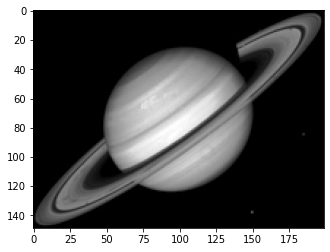

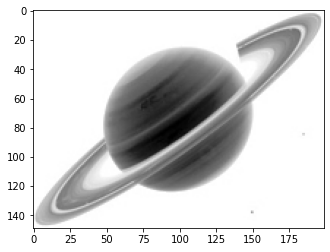

In [6]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique el tipo de transformacion. imagen binaria = true; negativa = falso
imagen_binaria = False #@param {type:"boolean"}
#@markdown ---

try:
  from datetime import datetime
  import matplotlib.pyplot as plt
  import numpy
  from PIL import Image
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule

  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  # Empiezo a contar el tiempo de procesamiento total
  tiempo_inicio_total = datetime.now()

  # Cargo la imagen guardada en el "Armado del ambiente"
  img_nombre = 'imagen.jpg'
  image = Image.open(img_nombre) 

  # Obtengo dimensiones de la imagen
  img_ancho, img_alto = image.size

  # Inicializo los valores para la transformacion binaria
  valor_inferior = 50
  valor_superior = 180
  
  # Muestro los atributos de la imagen
  print("Imagen 1: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )
  if valor_inferior < 0 or valor_superior > 255:
    raise Exception("El rango de valores para la imagen debe ser desde 0 hasta 255")
  
  # Convierto la imagen comprimida en JPEG/PNG a array
  img1_cpu = numpy.asarray(image)

  # Genero el array resultado (3 pixeles usa RGB * (el tamaño del array))
  img_result_cpu = numpy.empty_like(img1_cpu)

  # Reservo los 3 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
  img1_gpu = cuda.mem_alloc(img1_cpu.nbytes)
  img_result_gpu = cuda.mem_alloc(img_result_cpu.nbytes)

  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod(img1_gpu, img1_cpu)
  cuda.memcpy_htod(img_result_gpu, img_result_cpu)

  # CPU - Defino las funciones kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img_binaria(int ancho, int alto, char *img1, char *img_R)
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {
      int valor = (int)img1[((idx + (idy * ancho)) * 3)];
      int val_inf = 50 - 127;
      int val_sup = 180 - 127;
      if(valor > val_inf && valor < val_sup){
        img_R[((idx + (idy * ancho)) * 3)] = (char) 255;
        img_R[((idx + (idy * ancho)) * 3) + 1] = (char) 255;
        img_R[((idx + (idy * ancho)) * 3) + 2] = (char) 255;
      }else{
        img_R[((idx + (idy * ancho)) * 3)] = (char) 0;
        img_R[((idx + (idy * ancho)) * 3) + 1] = (char) 0;
        img_R[((idx + (idy * ancho)) * 3) + 2] = (char) 0;
      }
    }
  }

  __global__ void kernel_img_negativa(int ancho, int alto, char *img1, char *img_R)
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {
      img_R[((idx + (idy * ancho)) * 3)] = 255 - img1[((idx + (idy * ancho)) * 3)];
      img_R[((idx + (idy * ancho)) * 3) + 1] = 255 - img1[((idx + (idy * ancho)) * 3) + 1];
      img_R[((idx + (idy * ancho)) * 3) + 2] = 255 - img1[((idx + (idy * ancho)) * 3) + 2];
    }
  }
  """)
  # CPU - Genero la función kernel.
  if imagen_binaria:
    kernel = module.get_function("kernel_img_binaria")
  else:
    kernel = module.get_function("kernel_img_negativa")

  dim_hilo_x = 16
  dim_bloque_x = numpy.int((img_ancho + dim_hilo_x-1) / dim_hilo_x)
  dim_hilo_y = 16
  dim_bloque_y = numpy.int((img_alto+dim_hilo_y-1) / dim_hilo_y)

  print("Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print("Total de Thread: [", dim_hilo_x * dim_bloque_x, ",", dim_hilo_y * dim_bloque_y, " ]", " = ", dim_hilo_x*  dim_bloque_x * dim_hilo_y * dim_bloque_y )
  
  # Empiezo a contar el tiempo de procesamiento total
  tiempo_inicio_gpu = datetime.now()

  kernel(numpy.int32(img_ancho), numpy.int32(img_alto), img1_gpu, img_result_gpu,  block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
  
  # Calculo el tiempo de procesamiento de la imagen
  tiempo_total_gpu = datetime.now() - tiempo_inicio_gpu

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh(img_result_cpu, img_result_gpu)

  # Muestro las imagen original
  plt.figure()
  imgplot = plt.imshow(img1_cpu)

  # Calculo el tiempo total de procesamiento
  tiempo_total = datetime.now() - tiempo_inicio_total

  # Muestro la imagen luego de aplicar la combinacion.
  plt.figure()
  imgplot = plt.imshow(img_result_cpu)

  # Muestro los valores calculados
  print("Tiempo total:", tiempo_en_ms(tiempo_total), "ms")
  print("Tiempo GPU:", tiempo_en_ms(tiempo_total_gpu), "ms")
except Exception as excep:
  print("Error: ", excep)

---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  @param                | Lectura de las direcciones URL de las imagenes (jpg) a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  @param                | Lectura del tipo de transformacion a aplicar.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  tiempo_en_ms          | Define una funcion para obtener el tiempo en milisegundos a partir de una fecha.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de las imagen.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      |  if-except             | Genera un error si los parametros no estan entre 0 y 255
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | Convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.
CPU      |  print()          | Muestra el tiempo total y el tiempo que tomo la funcion GPU.

---
# 5 Conclusiones
### Breve repaso
En este ejercicio se aplican 2 operaciones puntuales a una imagen.
Operador Inverso o Negativo: transforma una imagen a sus colores inversos.
Operador Intervalo de Umbral Binario: transforma una imagen en escala de grises a una imagen binaria, donde los colores (blanco y negro) dependen de un rango determinado.

### Lecciones aprendidas
Como conclusion podemos observar que al realizar la transformacion de la imagen en forma paralela, usando threads del GPU, dicha transformacion se realiza mucho mas rapido que si se hiciera secuencialmente. Si bien la inicializacion toma bastante tiempo, al tratarse de una transformacion de una imagen, el procesamiento siempre sera grande, por lo que termina siendo mas eficiente.

### Sugerencias para continuar
El ejercicio se podria continuar agregando mas operaciones puntuales tales como "Operador Umbral", "Operador Intervalo de Umbral Binario Invertido", "Operador Umbral de la Escala de Grises", etc.

---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] Operaciones puntuales para imagenes: [Web](https://sites.google.com/site/lemared/operaciones-puntuales-sobre-imagenes)